In [ ]:
pip install transformers torch

In [ ]:
pip install datasets --upgrade

In [ ]:
pip install datasets

In [ ]:
pip install huggingface_hub --upgrade

In [ ]:
!pip install accelerate -U

In [ ]:
import torch
from transformers import GPTJForCausalLM, AutoTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AdamW

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Load the dataset
dataset = load_dataset("databricks/databricks-dolly-15k")

# Print information about the dataset
print(dataset)

# Inspect the structure of the dataset, e.g., columns and splits
print("Splits in the dataset:", dataset.keys())
print("Columns in the train split:", dataset['train'].column_names)


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})
Splits in the dataset: dict_keys(['train'])
Columns in the train split: ['instruction', 'context', 'response', 'category']


In [ ]:
print(dataset['train'][0])  # Show an example entry from the training set

{'instruction': 'When did Virgin Australia start operating?', 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.", 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa'}


In [ ]:
# Check the dataset splits
print("Dataset Splits:", dataset.keys())

# View the first few examples from the train split
print("Sample Data from the Train Split:")
print(dataset['train'][:5])


Dataset Splits: dict_keys(['train'])
Sample Data from the Train Split:
{'instruction': ['When did Virgin Australia start operating?', 'Which is a species of fish? Tope or Rope', 'Why can camels survive for long without water?', "Alice's parents have three daughters: Amy, Jessy, and what’s the name of the third daughter?", 'When was Tomoaki Komorida born?'], 'context': ["Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.", '', '', '', 'Komorida was born in Kumamoto Prefecture on July 10, 1981. After graduating from high school, he join

In [ ]:
# Split the training data to create new validation and test sets
train_testvalid = dataset['train'].train_test_split(test_size=0.2)  # Reserve 20% of the data for testing and validation
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)  # Split the reserved 20% equally into test and validation sets

# Assign these splits to variables
train_dataset = train_testvalid['train']  # Remaining 80% for training
valid_dataset = test_valid['test']        # 10% of the original dataset for validation
test_dataset = test_valid['train']        # 10% of the original dataset for testing

# Print the sizes of each split to confirm
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 12008
Validation set size: 1502
Test set size: 1501


In [ ]:
# Inspect a sample from each split
print("Sample from training set:", train_dataset[0])
print("Sample from validation set:", valid_dataset[0])
print("Sample from test set:", test_dataset[0])


Sample from training set: {'instruction': 'How would the world look like in say 200 years from now?', 'context': '', 'response': 'What I envision will happen in the future, say, in a 100 years is that we will have a world with all self sustaining technology. We will be harnessing power easily from abundant natural resources inside and outside of the solar system. All work will be automated and done by machines. Human labor will not be required anymore, be it in the factories or service industry or even in the medical fields. The elite class or the top 1% rich in the world will own all of the corporations and run it. They will not need the rest of the 99% of people in the world as they do will not require their services to run factories and corporations and make them profitable. The elite will see them including any existing forms of their government as a liability. There would be absolutely no functioning government in any part of the world and access to the elite cities or areas will 

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

In [ ]:
# First, check if the tokenizer has an EOS token, and whether it's set as the pad token
print("EOS Token:", tokenizer.eos_token)
print("Current Pad Token:", tokenizer.pad_token)

# If the pad token is None, set it explicitly to the EOS token or add a new one
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        # If there is no EOS token, add a new pad token
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        # You must resize the token embeddings when you add new tokens
        model.resize_token_embeddings(len(tokenizer))


EOS Token: <|endoftext|>
Current Pad Token: None


In [ ]:
# Tokenize function
def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples['context'], truncation=True, padding="max_length", max_length=512)
    tokenized_labels = tokenizer(examples['response'], truncation=True, padding="max_length", max_length=512)
    return {'input_ids': tokenized_inputs['input_ids'],
            'attention_mask': tokenized_inputs['attention_mask'],
            'labels': tokenized_labels['input_ids']}


# Apply tokenization to each split
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_valid = valid_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/12008 [00:00<?, ? examples/s]

Map:   0%|          | 0/1502 [00:00<?, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader

# Define a function to collate data samples into batches
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids'], dtype=torch.long) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch])
    labels = torch.stack([torch.tensor(item['labels'], dtype=torch.long) for item in batch])

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}


# Create the DataLoader for each split
train_loader = DataLoader(tokenized_train, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=4)
valid_loader = DataLoader(tokenized_valid, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=4)
test_loader = DataLoader(tokenized_test, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=4)


In [ ]:
first_batch = next(iter(train_loader))
print(first_batch)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'input_ids': tensor([[50256, 50256, 50256,  ..., 50256, 50256, 50256],
        [50256, 50256, 50256,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'labels': tensor([[39499,   267,   293,  ..., 50256, 50256, 50256],
        [  464,   749, 11282,  ..., 50256, 50256, 50256]])}


In [ ]:
#training on gpu
import torch
from transformers import AdamW

# Check if CUDA is available and select device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear unused memory and attempt to move model to GPU if sufficient memory is available
if device.type == 'cuda':
    torch.cuda.empty_cache()  # Clear unused memory
    total_memory = torch.cuda.get_device_properties(0).total_memory
    reserved_memory = torch.cuda.memory_reserved(0)
    free_memory = total_memory - reserved_memory
    required_memory = 256 * 1024 * 1024  # Example: Assume model needs 256MB

    print(f"Total GPU memory: {total_memory}, Reserved memory: {reserved_memory}, Free memory: {free_memory}, Required memory: {required_memory}")

    if free_memory >= required_memory:
        model = model.to(device)
        print("Model moved to GPU.")
    else:
        print("Not enough GPU memory. Running on CPU instead.")
        device = torch.device("cpu")
        model = model.to(device)
else:
    model = model.to(device)
    print("Using CPU.")

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


Total GPU memory: 16935682048, Reserved memory: 0, Free memory: 16935682048, Required memory: 268435456
Model moved to GPU.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#training on gpu
from tqdm import tqdm  # for nice progress bars

# Define the number of epochs
epochs = 5

# Training loop
model.train()  # set the model to training mode
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader):  # iterate over batches
        # Move batch data to the device
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss  # model outputs are always tuple in transformers (see doc)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {total_loss / len(train_loader)}')


100%|██████████| 6004/6004 [06:46<00:00, 14.76it/s]


Epoch 1/5, Average Loss: 1.3819882393821448


100%|██████████| 6004/6004 [06:45<00:00, 14.79it/s]


Epoch 2/5, Average Loss: 1.3613103874447166


100%|██████████| 6004/6004 [06:46<00:00, 14.77it/s]


Epoch 3/5, Average Loss: 1.3555210476007802


100%|██████████| 6004/6004 [06:46<00:00, 14.78it/s]


Epoch 4/5, Average Loss: 1.3588480589307006


100%|██████████| 6004/6004 [06:45<00:00, 14.79it/s]

Epoch 5/5, Average Loss: 1.3492918250155321


In [ ]:
pip install torchsummary

In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [ ]:
# #Save the Model
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [ ]:
# # Specify the path in your Google Drive
# save_path = '/content/drive/MyDrive/Comp646/Project/distilgpt2'

# # Save the model and tokenizer
# model.save_pretrained(save_path)
# tokenizer.save_pretrained(save_path)

In [ ]:
# #keep on cpu, very slow
# import torch
# from transformers import AdamW

# # Explicitly set the device to CPU
# device = torch.device("cpu")

# # Ensure the model is on the CPU
# model = model.to(device)

# # Set up the optimizer
# optimizer = AdamW(model.parameters(), lr=5e-5)


In [ ]:
# #training on cpu, very slow
# from tqdm import tqdm


# # Training loop
# model.train()  # set the model to training mode
# epochs = 5
# for epoch in range(epochs):
#     total_loss = 0
#     for batch in tqdm(train_loader):  # iterate over batches
#         inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
#         labels = batch['labels'].to(device)  # Ensure labels are properly referenced

#         # Forward pass
#         outputs = model(**inputs, labels=labels)
#         loss = outputs.loss

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     # Print average loss for the epoch
#     print(f'Epoch {epoch+1}/{epochs}, Average Loss: {total_loss / len(train_loader)}')


In [ ]:
# Validation loop
model.eval()  # set the model to evaluation mode
total_eval_loss = 0
with torch.no_grad():  # no gradient is needed for validation
    for batch in valid_loader:
        # Move batch data to the GPU
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss

        total_eval_loss += loss.item()

    # Print average validation loss
    print(f'Validation Loss: {total_eval_loss / len(valid_loader)}')


Validation Loss: 1.4272791064293502


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# from transformers import AutoModelForCausalLM, AutoTokenizer

# # Specify the path where the model and tokenizer were saved
# save_path = "/content/drive/MyDrive/Comp646/Project/distilgpt2"

# # Load the model and tokenizer
# model = AutoModelForCausalLM.from_pretrained(save_path)
# tokenizer = AutoTokenizer.from_pretrained(save_path)

100%|██████████| 6004/6004 [06:48<00:00, 14.71it/s]


Epoch 1/10, Training Loss: 1.337136993918079, Validation Loss: 1.4385942797884643, Test Loss: 1.3103747157536239


100%|██████████| 6004/6004 [06:48<00:00, 14.69it/s]


Epoch 2/10, Training Loss: 1.382669642212727, Validation Loss: 1.5025725254563296, Test Loss: 1.3671449333548387


100%|██████████| 6004/6004 [06:48<00:00, 14.71it/s]


Epoch 3/10, Training Loss: 1.3773747175165032, Validation Loss: 1.4823614642639136, Test Loss: 1.352014927627561


100%|██████████| 6004/6004 [06:47<00:00, 14.72it/s]


Epoch 4/10, Training Loss: 1.4446196066864645, Validation Loss: 1.5279788022610383, Test Loss: 1.3985876963038577


100%|██████████| 6004/6004 [06:48<00:00, 14.69it/s]


Epoch 5/10, Training Loss: 1.4593584539491602, Validation Loss: 1.4676987995875976, Test Loss: 1.3527022453344932


100%|██████████| 6004/6004 [06:48<00:00, 14.68it/s]


Epoch 6/10, Training Loss: 1.4084033490326764, Validation Loss: 1.504537773929963, Test Loss: 1.3888714951022805


100%|██████████| 6004/6004 [06:48<00:00, 14.68it/s]


Epoch 7/10, Training Loss: 1.4101849072063708, Validation Loss: 1.4729049342886587, Test Loss: 1.3410659748093583


100%|██████████| 6004/6004 [06:48<00:00, 14.68it/s]


Epoch 8/10, Training Loss: 1.4368070211735549, Validation Loss: 1.4937330287956843, Test Loss: 1.3646986963706074


100%|██████████| 6004/6004 [06:49<00:00, 14.68it/s]


Epoch 9/10, Training Loss: 1.4184200922393306, Validation Loss: 1.4758196412802695, Test Loss: 1.348420938722462


100%|██████████| 6004/6004 [06:48<00:00, 14.69it/s]


Epoch 10/10, Training Loss: 1.415759217016384, Validation Loss: 1.5089354257331231, Test Loss: 1.384909959849759


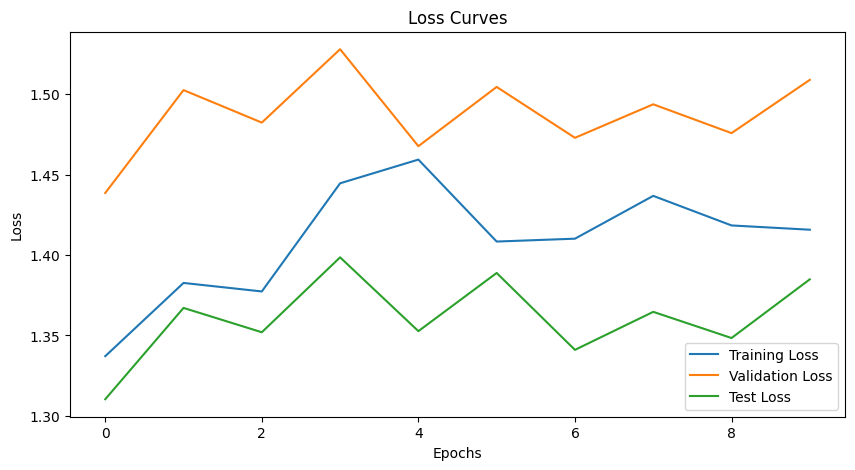

In [ ]:
import matplotlib.pyplot as plt

def evaluate(model, loader, device):
    model.eval()  # set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # deactivate autograd
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            total_loss += outputs.loss.item()
    return total_loss / len(loader)

# Lists to store loss values
train_losses = []
valid_losses = []
test_losses = []
epochs = 10
# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    avg_valid_loss = evaluate(model, valid_loader, device)
    valid_losses.append(avg_valid_loss)

    avg_test_loss = evaluate(model, test_loader, device)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Test Loss: {avg_test_loss}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from transformers import TextGenerationPipeline

# Assume the model and tokenizer are loaded and configured
generator = TextGenerationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=-1 if not torch.cuda.is_available() else 0,  # Device configuration
    truncation=True,  # Enable truncation to the maximum length
    max_length=1500,  # Set the maximum length for generated sequences
    do_sample=True,  # Enable sampling to generate diverse responses
    num_return_sequences=1  # Generate one sequence per input
)

# Example: Generate responses based on the 'context' from test data
for example in test_dataset.shuffle().select(range(10)):  # Shuffle and select 10 examples for evaluation
    prompt = example['context']
    generated_responses = generator(prompt)  # Pass the raw text directly

    print(f"Context: {prompt}")
    print(f"Generated Response: {generated_responses[0]['generated_text']}")
    print(f"Actual Response: {example['response']}")
    print("-----")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may 

Context: The best approach to specifically achieve muscle growth remains controversial (as opposed to focusing on gaining strength, power, or endurance); it was generally considered that consistent anaerobic strength training will produce hypertrophy over the long term, in addition to its effects on muscular strength and endurance. Muscular hypertrophy can be increased through strength training and other short-duration, high-intensity anaerobic exercises. Lower-intensity, longer-duration aerobic exercise generally does not result in very effective tissue hypertrophy; instead, endurance athletes enhance storage of fats and carbohydrates within the muscles, as well as neovascularization.
Generated Response: The best approach to specifically achieve muscle growth remains controversial (as opposed to focusing on gaining strength, power, or endurance); it was generally considered that consistent anaerobic strength training will produce hypertrophy over the long term, in addition to its effe

In [ ]:
# Evaluate using your chosen metric, e.g., perplexity
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

# Calculate perplexity based on total loss
perplexity = torch.exp(torch.tensor(total_loss / len(test_loader)))
print(f"Perplexity: {perplexity}")



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Perplexity: 3.9944663047790527
